# Modelling

---

# Contents

- [1.0 Arima Model](#1.0-ARIMA-Model)
- [2.0 Daily Data](#2.0-Daily-Data)
    - [1.1 Load Data](#2.1-Load-Data)
    - [1.2 Train Test Split](#2.2-Train-Test-Split)

In [1]:
# !pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA, ARMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, mean_squared_error
from pmdarima import auto_arima
import plotly.graph_objects as go

In [3]:
pd.set_option('display.max_columns', None)

---

# 1.0 ARIMA Model

The Arima model has 3 components:

+ Differencing Step - I - Integrated - Check for stationarity
+ Autoregressive Piece - AR - long term trends
+ Moving Average Piece - MA - Modelling sudden fluctuations

Each part has input into the model P,D,Q. I will use the previous Dickey Fuller 

+ D is the order of differencing we found using the Augmented Dickey-Fuller test.
+ P is the number of autoregressive terms in our model. PACF is used to estimate this.
+ Q is to do with looking at the moving average.
    + If PACF has a sharp cut off and lag-1 for the ACF is negative choose q to be the lag in the ACF before cut off.
    + If PACF does not have a sharp cut off or lag -1 ACF is not negative choose q = 0

Therefore based on the charts before I will use:
    
    + p = 1
    + d = 1
    + q = 0
    
However I will use auto_arima to help decide.

---

## 1.1 Load Data

In [4]:
daily = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/resampled/daily.csv', 
                    index_col='date', parse_dates=True)

In [5]:
daily_pattern = pd.read_csv('/Users/stuartdaw/Documents/Capstone_data/data/targets/daily_pattern.csv', 
                           parse_dates=True)

In [6]:
daily.index

DatetimeIndex(['2000-05-30', '2000-05-31', '2000-06-01', '2000-06-02',
               '2000-06-05', '2000-06-06', '2000-06-07', '2000-06-08',
               '2000-06-09', '2000-06-12',
               ...
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-23',
               '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=5045, freq=None)

In [7]:
daily.columns

Index(['open', 'high', 'low', 'close', 'marubozu', 'marubozu+1', 'marubozu-1',
       'marubozu-2', 'height', 'av_3_height', 'wk_mv_av', 'mnth_mv_av',
       'qtr_mv_av', 'day-1_open', 'day-2_open', 'day-3_open', 'day-1_high',
       'day-2_high', 'day-3_high', 'day-1_low', 'day-2_low', 'day-3_low',
       'day-1_close', 'day-2_close', 'day-3_close', 'day+1_open', 'day+1_high',
       'day+1_low', 'day+1_close', 'day+2_high', 'day+3_high', 'target',
       'select'],
      dtype='object')

In [8]:
daily = daily.resample('B').agg({'open':'first','high':'max','low':'min', 'close':'last'})


In [9]:
daily.index

DatetimeIndex(['2000-05-30', '2000-05-31', '2000-06-01', '2000-06-02',
               '2000-06-05', '2000-06-06', '2000-06-07', '2000-06-08',
               '2000-06-09', '2000-06-12',
               ...
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-23',
               '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='date', length=5111, freq='B')

In [10]:
daily.shape

(5111, 4)

In [11]:
daily.isnull().sum()

open     66
high     66
low      66
close    66
dtype: int64

In [12]:
daily.head()

,open,high,low,close
date,,,,
2000-05-30,0.9302,0.9302,0.9302,0.9302
2000-05-31,0.9315,0.9382,0.9151,0.9377
2000-06-01,0.9376,0.9380,0.9287,0.9315
2000-06-02,0.9313,0.9498,0.9308,0.9443
2000-06-05,0.9444,0.9490,0.9416,0.9463


In [13]:
daily.index.is_all_dates

True

In [14]:
daily_pattern['pattern_end'] = pd.to_datetime(daily_pattern['pattern_end'])

In [15]:
daily_pattern.head()

,pattern_end
0,2000-05-31
1,2000-10-10
2,2000-10-19
3,2001-02-08
4,2001-04-04


---

## 1.2 Train Test Split

In [16]:
# Test 1 date out
daily.loc[daily.index == daily_pattern.loc[10]['pattern_end']].index[0]

Timestamp('2004-01-28 00:00:00', freq='B')

In [17]:
# save date
train_stop = daily.loc[daily.index == daily_pattern.loc[10]['pattern_end']].index[0]

In [18]:
daily.loc[:train_stop].index

DatetimeIndex(['2000-05-30', '2000-05-31', '2000-06-01', '2000-06-02',
               '2000-06-05', '2000-06-06', '2000-06-07', '2000-06-08',
               '2000-06-09', '2000-06-12',
               ...
               '2004-01-15', '2004-01-16', '2004-01-19', '2004-01-20',
               '2004-01-21', '2004-01-22', '2004-01-23', '2004-01-26',
               '2004-01-27', '2004-01-28'],
              dtype='datetime64[ns]', name='date', length=957, freq='B')

In [19]:
train_and_test = daily.iloc[:len(daily.loc[:train_stop].index)+30]

In [20]:
train = train_and_test.iloc[:len(daily.loc[:train_stop].index)]
test = train_and_test.iloc[len(daily.loc[:train_stop].index):]

In [21]:
start=len(train)
end=len(train)+len(test)-1
start, end

(957, 986)

In [22]:
# start = train_stop
# end = test.index[-1]
# start, end

In [23]:
train.head()

,open,high,low,close
date,,,,
2000-05-30,0.9302,0.9302,0.9302,0.9302
2000-05-31,0.9315,0.9382,0.9151,0.9377
2000-06-01,0.9376,0.9380,0.9287,0.9315
2000-06-02,0.9313,0.9498,0.9308,0.9443
2000-06-05,0.9444,0.9490,0.9416,0.9463


In [24]:
train.index

DatetimeIndex(['2000-05-30', '2000-05-31', '2000-06-01', '2000-06-02',
               '2000-06-05', '2000-06-06', '2000-06-07', '2000-06-08',
               '2000-06-09', '2000-06-12',
               ...
               '2004-01-15', '2004-01-16', '2004-01-19', '2004-01-20',
               '2004-01-21', '2004-01-22', '2004-01-23', '2004-01-26',
               '2004-01-27', '2004-01-28'],
              dtype='datetime64[ns]', name='date', length=957, freq='B')

In [33]:
train = train[['close']]

KeyError: "None of [Index(['close'], dtype='object', name='date')] are in the [index]"

In [34]:
test = test[['close']]

KeyError: "None of [Index(['close'], dtype='object', name='date')] are in the [index]"

In [27]:
train.index

DatetimeIndex(['2000-05-30', '2000-05-31', '2000-06-01', '2000-06-02',
               '2000-06-05', '2000-06-06', '2000-06-07', '2000-06-08',
               '2000-06-09', '2000-06-12',
               ...
               '2004-01-15', '2004-01-16', '2004-01-19', '2004-01-20',
               '2004-01-21', '2004-01-22', '2004-01-23', '2004-01-26',
               '2004-01-27', '2004-01-28'],
              dtype='datetime64[ns]', name='date', length=957, freq='B')

In [28]:
def train_test_plot(train, test):
    plt.figure(figsize=(16, 8))
    plt.plot(train, c='blue')
    plt.plot(test, c='orange');

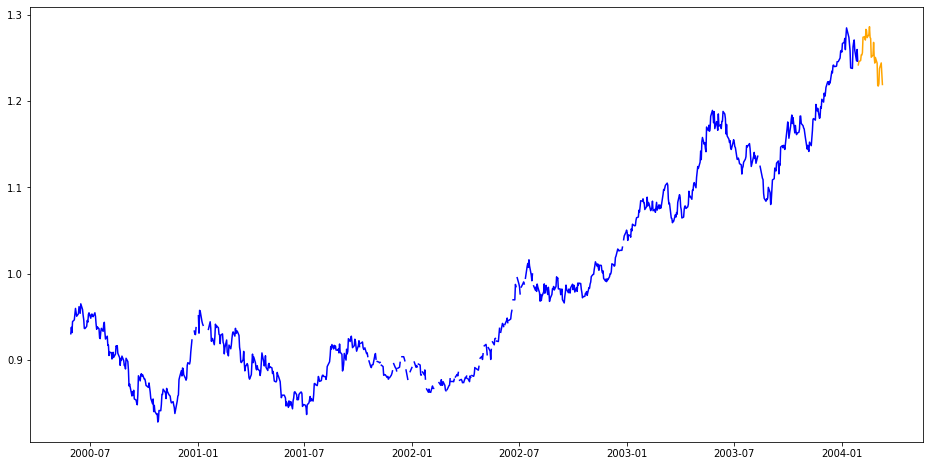

In [29]:
# This plot confirms that our train test split makes sense
train_test_plot(train, test)

In [30]:
auto_arima(daily['close'].dropna(), seasonal=False).summary()

/Users/stuartdaw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/stuartdaw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/stuartdaw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5045
Model:               SARIMAX(0, 1, 0)   Log Likelihood               17488.067
Date:                Thu, 23 Jul 2020   AIC                         -34974.133
Time:                        18:30:07   BIC                         -34967.607
Sample:                             0   HQIC                        -34971.847
                               - 5045                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.701e-05   7.42e-07     76.831      0.000    5.56e-05    5.85e-05
===================================================================================
Ljung-Box (Q):                       31.43   Jarque-Bera (JB):              1508.87
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
train

date
2000-05-30    0.9302
2000-05-31    0.9377
2000-06-01    0.9315
2000-06-02    0.9443
2000-06-05    0.9463
               ...  
2004-01-22    1.2707
2004-01-23    1.2587
2004-01-26    1.2464
2004-01-27    1.2597
2004-01-28    1.2461
Freq: B, Name: close, Length: 957, dtype: float64

In [32]:
model = ARIMA(train['close'], order=(0,1,0))
results = model.fit()
results.summary()

KeyError: 'close'

In [ ]:
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA-0-1-0 Predictions')

In [ ]:
train, test

In [ ]:
predictions

In [ ]:
predictions.index

In [ ]:
test.head()['close'].isnull().sum()

In [ ]:
train.head()['close'].isnull().sum()

In [ ]:
test['close'].plot(legend=True, figsize=(12,8))
# predictions.plot(legend=True)